<a href="https://colab.research.google.com/github/amgothhrithik/American-Sign-Language/blob/main/ASL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 9.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json when prompted


Saving kaggle (5).json to kaggle (5).json


{'kaggle (5).json': b'{"username":"hrithik1409","key":"876e8deed61734d935db12769a1e4a8a"}'}

In [ ]:
import os
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set file permissions


In [ ]:
!kaggle datasets download -d grassknoted/asl-alphabet


Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
100% 1.02G/1.03G [00:11<00:00, 105MB/s] 
100% 1.03G/1.03G [00:11<00:00, 92.7MB/s]


In [ ]:
import zipfile

dataset_path = "asl-alphabet.zip"  # Change this if needed
with zipfile.ZipFile(dataset_path, "r") as zip_ref:
    zip_ref.extractall("ASL_Data")


In [ ]:
import os
import mediapipe as mp
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
mp_hand=mp.solutions.hands

# .hands Module

* The `.hands` module specifically provides *hand tracking and gesture recognition* functionality.
* Provides 21 keypoints(landmarks) for each detected hand.

Key Components:
* `.Hands()` → Initializes the hand tracking model.
* `.process(image)` → Processes the input image to detect hands.
* `.multi_hand_landmarks` → Stores detected hand landmarks.

In [ ]:
mp_drawing=mp.solutions.drawing_utils

* `.download_utils` module used for visualizing *detected landmarks* in images or videos.

In [ ]:
mp_drawing_style=mp.solutions.drawing_styles

In [ ]:
hands = mp_hand.Hands(static_image_mode=True, min_detection_confidence=0.7)

In [ ]:
data_dir="ASL_Data/asl_alphabet_train/asl_alphabet_train"
data=[]
labels=[]
for i in sorted(os.listdir(data_dir)):
  if i !=".DS_Store":
    path1=os.path.join(data_dir,i)
    for j in os.listdir(path1):

      img = cv2.imread(os.path.join(path1,j))
      img_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
      results=hands.process(img_rgb)
      if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
          data_aux=[]
          for keypt in hand_landmarks.landmark:
            x=keypt.x
            y=keypt.y
            data_aux.append(x)
            data_aux.append(y)
        data.append(data_aux)

        labels.append(i)






# save data
f = open('data.pickle', 'wb')
pickle.dump({'data':data,'labels':labels},f)
f.close()


In [ ]:
len(labels)

59766

In [ ]:
data_dir_test="ASL_Data/asl_alphabet_test/asl_alphabet_test"
data_test=[]
labels_test=[]
for i in sorted(os.listdir(data_dir_test)):
  data_aux=[]
  path1=os.path.join(data_dir_test,i)
  img = cv2.imread(path1)
  img_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  results=hands.process(img_rgb)
  if results.multi_hand_landmarks:
    for hand_landmarks in results.multi_hand_landmarks:
      for keypt in hand_landmarks.landmark:
        x=keypt.x
        y=keypt.y
        data_aux.append(x)
        data_aux.append(y)
    data_test.append(data_aux)
    labels_test.append(i)

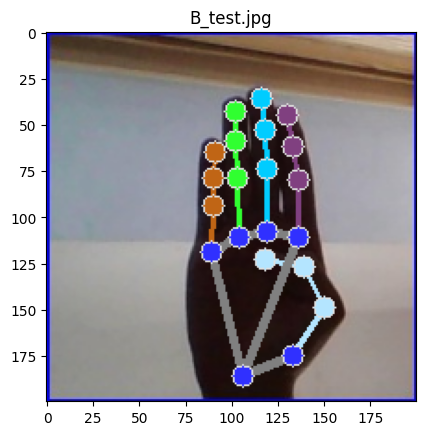

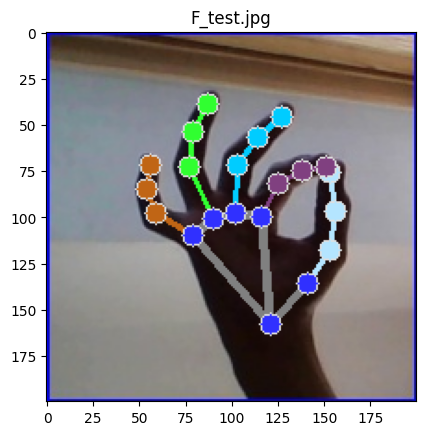

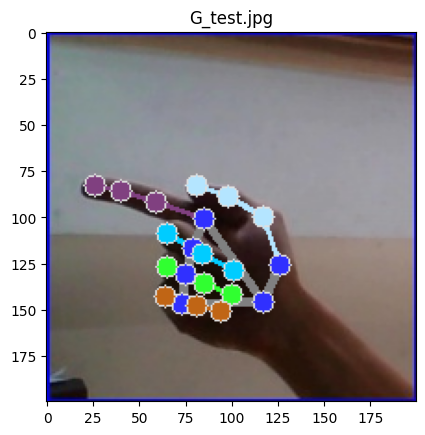

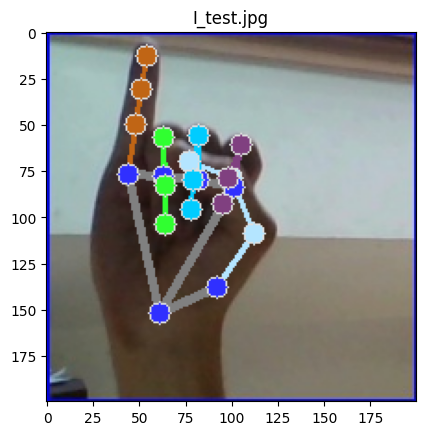

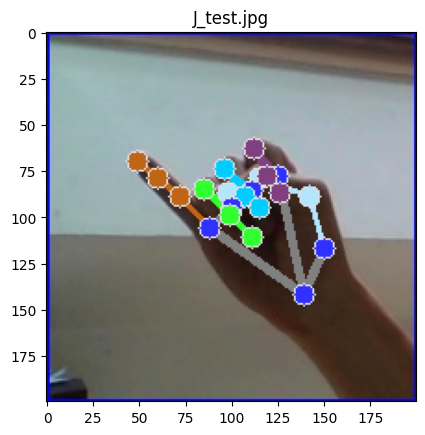

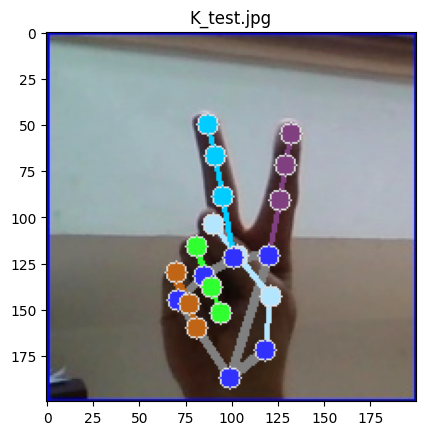

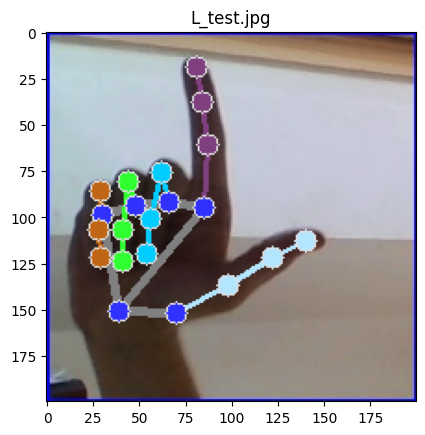

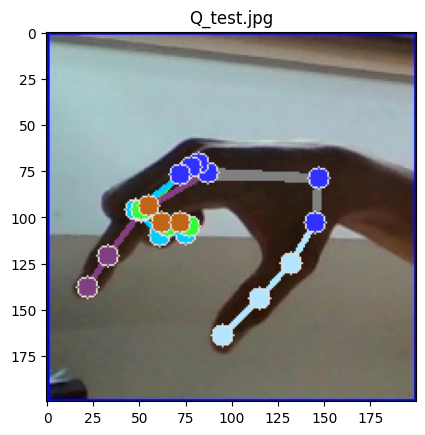

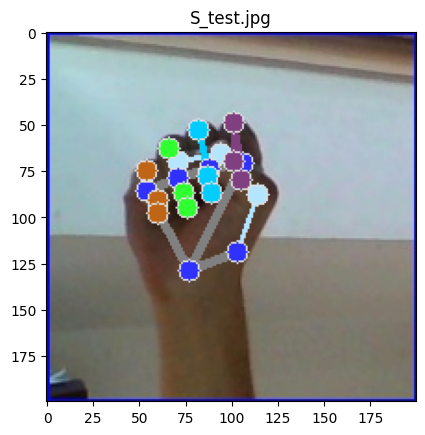

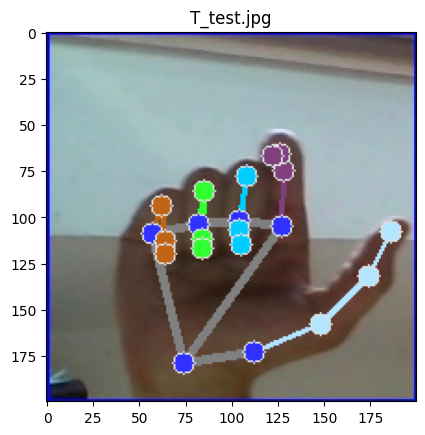

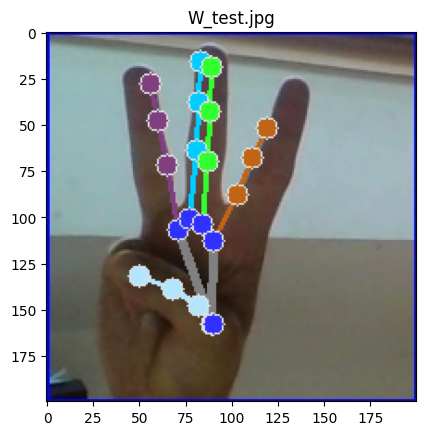

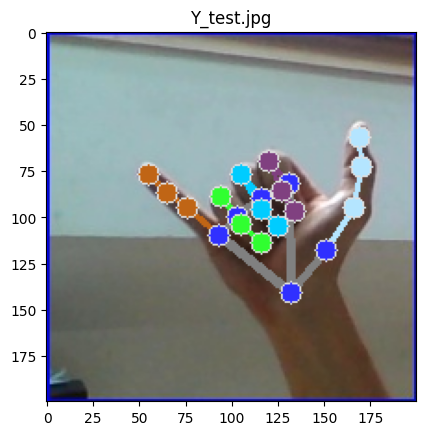

In [ ]:
for i in sorted(os.listdir(data_dir_test)):
  img = cv2.imread(os.path.join(data_dir_test,i))
  img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

  results = hands.process(img_rgb)
  if results.multi_hand_landmarks:
    for hand_landmarks in results.multi_hand_landmarks:
      mp_drawing.draw_landmarks(
          img_rgb,  # Image to draw on
          hand_landmarks,
          mp_hand.HAND_CONNECTIONS,
          mp_drawing_style.get_default_hand_landmarks_style(),
          mp_drawing_style.get_default_hand_connections_style()
      )



    plt.figure()
    plt.title(i)
    plt.imshow(img_rgb)
plt.show()

In [ ]:
filtered_data = []
filtered_labels = []

for i in range(len(data)):
    if len(data[i]) == 42:
        filtered_data.append(data[i])
        filtered_labels.append(labels[i])

data = filtered_data
labels = filtered_labels


X = np.array(data, dtype=np.float32)  # Convert to float if numeric


In [ ]:
print(len(data))

59729


In [ ]:
from sklearn.utils import shuffle

X_train, X_test, y_train, y_test = train_test_split(np.array(data), labels, test_size=0.15, random_state=22, shuffle=True)
# model
model = RandomForestClassifier(random_state=22)
model.fit(X_train,y_train)



RandomForestClassifier(random_state=22)

In [ ]:
# predict
pred=model.predict(X_test)

# accruracy
accuracy_score(y_test,pred)

0.9900669642857143

In [ ]:
# save model
f = open('/content/drive/MyDrive/Data/ASL/model_pre.p', 'wb')
pickle.dump({'model_pre':model},f)
f.close()

In [ ]:
cap = cv2.VideoCapture(0)

with mp_hand.Hands(min_detection_confidence=0.8, min_tracking_confidence=0.8) as hands:
    while cap.isOpened():

        data_aux=[]
        x_ = []
        y_ = []

        ret, frame = cap.read()
        H, W, _ = frame.shape

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_rgb = cv2.flip(frame_rgb, 1)
        frame_rgb.flags.writeable = False
        results = hands.process(frame_rgb)
        frame_rgb.flags.writeable = True
        frame_rgb = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    frame_rgb, # img to draw
                    hand_landmarks,
                    mp_hand.HAND_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(28, 255, 3), thickness=5, circle_radius=10),
                    mp_drawing.DrawingSpec(color=(236, 255, 3), thickness=5, circle_radius=10)
                )


            for hand_landmarks in results.multi_hand_landmarks:
                for i in range(len(hand_landmarks.landmark)):
                    x = hand_landmarks.landmark[i].x
                    y = hand_landmarks.landmark[i].y
                    data_aux.append(x)
                    data_aux.append(y)
                    x_.append(x)
                    y_.append(y)

            x1 = int(min(x_) * W)-10
            y1 = int(min(y_) * H)-10

            x2 = int(max(x_) * W)-10
            y2 = int(max(y_) * H)-10
            prediction = model.predict([np.array(data_aux)[0:42]])[0]

            cv2.rectangle(frame_rgb, (x1,y1-10), (x2,y2), (255,99,173), 6)
            cv2.putText(frame_rgb, prediction, (x1,y1), cv2.FONT_HERSHEY_DUPLEX, 5, (255,0,0), 5, cv2.LINE_AA)

        cv2.imshow('frame',frame_rgb)
        # cv2.waitKey(1)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()